In [336]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
sns.set(style="white") # reset font size

In [337]:
# path to dataset properties file
dataset_properties = pd.read_csv("../results/datasets/classification_binary_datasets.csv") 

# 1. Datasets: Number of features distribution

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

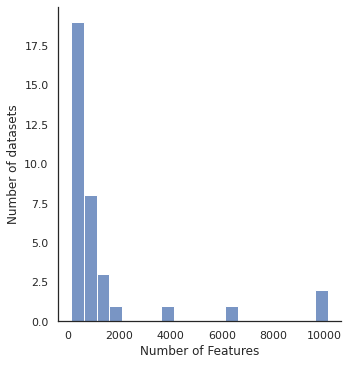

In [338]:
number_of_features = dataset_properties["NumberOfFeatures"].values

ax = sns.displot(number_of_features, binwidth=500)
ax.set(xlabel='Number of Features', ylabel='Number of datasets')
ax.savefig('dataset_feature_distribution.eps')

# 2. Iteration Experiment Evaluation

In [410]:
iter_experiment_path = "../results/iteration_number_experiment/"
iter_experiment_output_path = "iter_experiment_plots/"

In [415]:
# read all iteration data
all_iteration_data = pd.DataFrame()
for root, dirs, files in os.walk(iter_experiment_path):
    for filename in files:
        if filename != ".gitignore":
            all_iteration_data = pd.concat([all_iteration_data, pd.read_csv(iter_experiment_path + filename, skiprows=[1])])

In [416]:
def printAllIterationsTestingScore(name, group):
    # group values for each approach
    gb = group.groupby(["Dataset ID", "Estimator", "Metric", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function"], as_index=False)
    grouped_data = [gb.get_group(x) for x in gb.groups]
    
    fig, ax = plt.subplots(5, 2, figsize=(15,20))
    
    ax[0,0].set_xlabel('Number of Iterations', size=15) 
    ax[0,0].set_ylabel('Score', size=15)

    y_min = 1
    y_max = 0
    
    for index in range(0,len(grouped_data)):
        if index < 2:
            i=0
            j=index
        elif index < 4:
            i=1
            j=index-2
        elif index < 6:
            i=2
            j=index-4
        elif index < 8:
            i=3
            j=index-6
        else:
            i=4
            j=index-8
            
        iteration_labels = grouped_data[index]["Iteration Steps"]
        testing_values = grouped_data[index]["Testing Score"]
        training_values = grouped_data[index]["Training Score"]
        ax[i,j].plot(iteration_labels, testing_values, label = "Testing")
        ax[i,j].plot(iteration_labels, training_values, label = "Training")
        title = grouped_data[index].loc[:, "Learning Method"].values[0] + "-" + grouped_data[index].loc[:, "Kernel"].values[0] + "-" + grouped_data[index].loc[:, "Discretization Method"].values[0]
        ax[i,j].set_title(title, size=20)
        ax[i,j].tick_params(labelsize=20)
        ax[i,j].legend()
        # set y axis range to the same for both subplots
        y_min = min(ax[i,j].get_ylim()[0], y_min)
        y_max = max(ax[i,j].get_ylim()[1], y_max)
        fig.tight_layout()
    
    # set y axis range
    for i, axis in enumerate(ax.flat):
        axis.set_ylim(y_min, y_max)
        
    return fig

In [ ]:
grouped_iteration_data_convergence = all_iteration_data.groupby(["Dataset ID", "Estimator", "Metric"])

for name, group in grouped_iteration_data_convergence:
    iter_plot = printAllIterationsTestingScore(name, group)
    # save plot to file
    filename = str(name[0]) + "_" + name[1] + "_" + name[2] + ".pdf"
    iter_plot.savefig(iter_experiment_output_path + "convergence/"+ filename, format="pdf", bbox_inches = "tight", dpi=1200)

In [423]:
def getCorrelationBetweenTestingTraining(name_estimator_metric, group_estimator_metric):
    grouped_approach = group_estimator_metric.groupby(["Learning Method", "Kernel", "Discretization Method", "Acquisition Function", "Number Features"])
    corr_values = {}
    
    for name_approach, group_approach in grouped_approach:
        if name_approach[0] == "RF":
            label = name_approach[0]+"-"+name_approach[2]
        else:
            label = name_approach[0]+"-"+name_approach[1]+"-"+name_approach[2]
        corr_values[label] = {}
        grouped_dataset = group_approach.groupby(["Dataset ID"])
        for name_dataset, group_dataset in grouped_dataset:
            corr_values[label][name_dataset] = group_dataset["Testing Score"].corr(group_dataset["Training Score"])
    df = pd.DataFrame(corr_values)
    return df

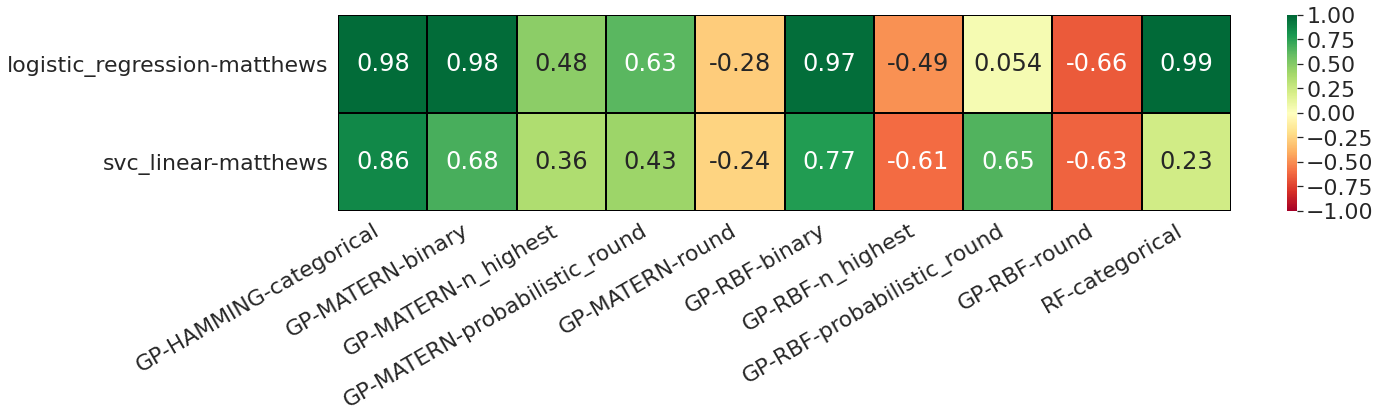

In [424]:
# create heatmap of average correlation between training and testing timeseries
grouped_iteration_data_correlation = all_iteration_data.groupby(["Estimator", "Metric"])

corr_df = pd.DataFrame()

for name, group in grouped_iteration_data_correlation:
    average_correlation = getCorrelationBetweenTestingTraining(name, group).mean()
    df = pd.DataFrame(average_correlation, index=average_correlation.index, columns = [name[0] + "-" + name[1]]).T
    corr_df = pd.concat([corr_df, df])

sns.set(font_scale=2) # font size 2
fig, ax = plt.subplots(figsize=(20,4)) 
ax = sns.heatmap(corr_df, vmin=-1, vmax=1, center=0, annot=True, cmap='RdYlGn', linewidths=1, linecolor="black")
fig.autofmt_xdate()
filename = "iter_correlation_heatmap.pdf"
fig.savefig(iter_experiment_output_path + "correlation/" + filename, format="pdf", bbox_inches = "tight", dpi=1200)
sns.set(style="white") # reset font size

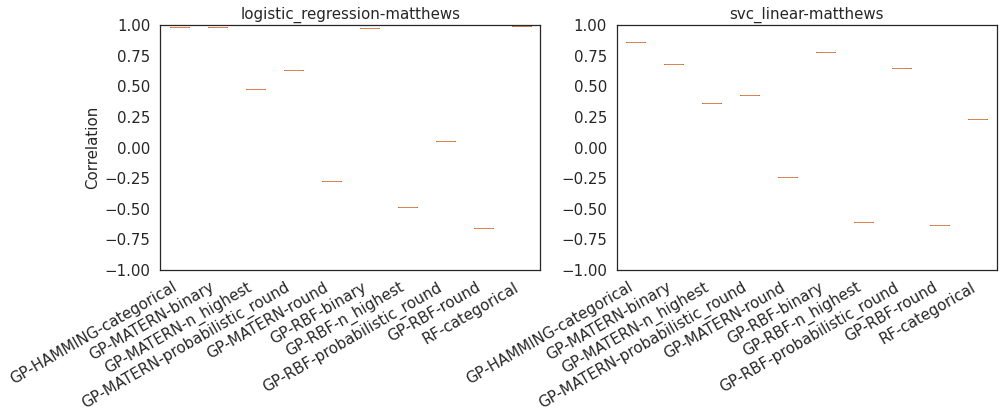

In [427]:
# create boxplot of average correlation
grouped_iteration_data_correlation = all_iteration_data.groupby(["Estimator", "Metric"])

data_dict = {}
for name, group in grouped_iteration_data_correlation:
    data_dict[name] = getCorrelationBetweenTestingTraining(name, group).reset_index(drop=True)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.boxplot(data_dict[list(data_dict.keys())[0]])
ax1.set_xticklabels(data_dict[list(data_dict.keys())[0]].columns)
title1 = list(data_dict.keys())[0][0] + "-" + list(data_dict.keys())[0][1]
ax1.set_title(title1, fontsize=15)
ax1.set_ylabel("Correlation", size=15)
ax1.tick_params(labelsize=15)
ax1.set_ylim(-1,1)
ax2.boxplot(data_dict[list(data_dict.keys())[1]])
ax2.set_xticklabels(data_dict[list(data_dict.keys())[1]].columns)
title2 = list(data_dict.keys())[1][0] + "-" + list(data_dict.keys())[1][1]
ax2.set_title(title2, fontsize=15)
ax2.tick_params(labelsize=15)
ax2.set_ylim(-1,1)
fig.autofmt_xdate()

filename = "iter_correlation_boxplot.pdf"
fig.savefig(iter_experiment_output_path + "correlation/" + filename, format="pdf", bbox_inches = "tight", dpi=1200)

# 3. Comparison Experiment

In [346]:
# path where the result csv files are stored
comparison_experiment_path = "../results/comparison_bayesian_experiment/classification/"
comparison_experiment_output_path = "comparison_experiment_plots/"

In [347]:
# Explore available data
dataset_set = set() # set of all dataset id, estimator and metric combinations
filename_list = []

# explore folder and store all dataset ids and filenames
file_list = os.listdir(comparison_experiment_path)
for file in file_list:
    if file.startswith("bayopt") or file.startswith("comparison") or file.startswith("withoutfs"):
        # get properties
        dataset_id = file.split("_")[1]
        estimator = file.split("_")[2] + "_" + file.split("_")[3]
        metric = file.split("_")[4].split(".")[0]
        dataset_set.add((dataset_id, estimator, metric))
        filename_list.append(file)

In [348]:
# Concatinate all bayesian, comparison and withoutfs into one dataframe
all_bayopt_data = pd.DataFrame()
all_comparison_data = pd.DataFrame()
all_withoutfs_data = pd.DataFrame()

for dataset_id, estimator, metric in dataset_set:
    path_suffix = dataset_id + "_" + estimator + "_" + metric + ".csv"
    
    # import bay opt
    bayopt_import= pd.read_csv(comparison_experiment_path + "bayopt_" + path_suffix, skiprows=[1])
    bayopt_import["did"] = dataset_id
    bayopt_import["Estimator"] = estimator
    bayopt_import["Metric"] = metric
    bayopt_import["did"] = pd.to_numeric(bayopt_import["did"]) # convert values to int
    
    # import comparison
    comparison_import = pd.read_csv(comparison_experiment_path + "comparison_" + path_suffix, skiprows=[1])
    comparison_import["did"] = dataset_id
    comparison_import["Estimator"] = estimator
    comparison_import["Metric"] = metric
    comparison_import["did"] = pd.to_numeric(comparison_import["did"]) # convert values to int
    
    # import withoutfs
    withoutfs_import = pd.read_csv(comparison_experiment_path + "withoutfs_" + path_suffix)
    if withoutfs_import.iloc[0,0] == "mean":
        withoutfs_import = pd.read_csv(comparison_experiment_path + "withoutfs_" + path_suffix, skiprows=[1])
    withoutfs_import["did"] = dataset_id
    withoutfs_import["Estimator"] = estimator
    withoutfs_import["Metric"] = metric
    withoutfs_import["did"] = pd.to_numeric(withoutfs_import["did"]) # convert values to int
    
    all_bayopt_data = pd.concat([all_bayopt_data, bayopt_import])
    all_comparison_data = pd.concat([all_comparison_data, comparison_import])
    all_withoutfs_data = pd.concat([all_withoutfs_data, withoutfs_import])

# replace strings
all_bayopt_data = all_bayopt_data.replace("Gaussian Process", "GP")
all_bayopt_data = all_bayopt_data.replace("Random Forest", "RF")
all_bayopt_data = all_bayopt_data.replace("Radial Basis Functions", "RBF")
all_comparison_data = all_comparison_data.replace("Recursive Feature Selection", "RFE")
all_comparison_data = all_comparison_data.replace("Sequential Feature Selection", "SFS")

## 3.1. Score Comparison

In [349]:
def create_bar_plot_of_scores(bayopt_data, comparison_data, withoutfs_data):
    """ Create plot with Bayesian optimization and comparison scores
    
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    bayopt_scores = bayopt_data["Testing Score"].values
    bayopt_labels = []
    for index, row in bayopt_data.iterrows():
        if row["Learning Method"] == "RF":
             bayopt_labels.append(row["Learning Method"] + " - " + row["Discretization Method"])
        else:
            bayopt_labels.append(row["Learning Method"] + " - " + row["Kernel"] + " - " + row["Discretization Method"])
    comparison_scores = comparison_data["Testing Score"].values
    comparison_labels = [row["Algorithm"] + " (" + row["Approach"] + ")" for index, row in comparison_data.iterrows()]
    withoutfs_score = withoutfs_data["Testing Score"][0]
    
    ax1.bar(bayopt_labels, bayopt_scores)
    ax1.set_title("BOFS")
    ax1.set_ylim(0,1)
    ax1.axhline(y=withoutfs_score)
    
    ax2.bar(comparison_labels, comparison_scores)
    ax2.set_title("Comparison")
    ax2.set_ylim(0,1)
    ax2.axhline(y=withoutfs_score)
    
    fig.autofmt_xdate()
    
    return fig


In [ ]:
for dataset_id, estimator, metric in dataset_set:
    path_suffix = dataset_id + "_" + estimator + "_" + metric + ".csv"
    
    # create dataframes
    bayopt_data = pd.read_csv(comparison_experiment_path + "bayopt_" + path_suffix, skiprows=[1])
    comparison_data = pd.read_csv(comparison_experiment_path + "comparison_" + path_suffix , skiprows=[1])
    withoutfs_data = pd.read_csv(comparison_experiment_path + "withoutfs_" + path_suffix)
    if withoutfs_data.iloc[0,0] == "mean":
        withoutfs_data = pd.read_csv(comparison_experiment_path + "withoutfs_" + path_suffix, skiprows=[1])
    
    # replace strings
    bayopt_data = bayopt_data.replace("Gaussian Process", "GP")
    bayopt_data = bayopt_data.replace("Random Forest", "RF")
    bayopt_data = bayopt_data.replace("Radial Basis Functions", "RBF")
    comparison_data = comparison_data.replace("Recursive Feature Selection", "RFE")
    comparison_data = comparison_data.replace("Sequential Feature Selection", "SFS")
    
    # create plot and save file

    plot = create_bar_plot_of_scores(bayopt_data, comparison_data, withoutfs_data)
    filename = dataset_id + "_" + estimator + "_" + metric + ".pdf"
    plot.savefig(comparison_experiment_output_path + "score_comparison/" + filename, format="pdf", bbox_inches = "tight")

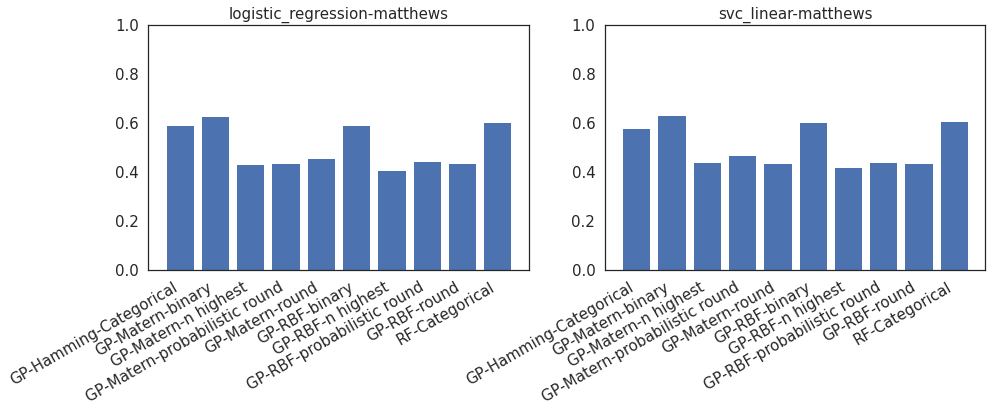

In [352]:
def createAverageScoreBarChart(bayopt_data):
    all_bayopt_data_grouped_estimator = all_bayopt_data.groupby(["Estimator", "Metric"])
    
    data_dict = dict()
    for name_estimator, group_estimator in all_bayopt_data_grouped_estimator:
        all_bayopt_data_grouped = group_estimator.groupby(["Approach", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function", "n_features"])
        data_dict[name_estimator[0] + "-" + name_estimator[1]] = {}
        for name, group in all_bayopt_data_grouped:
            if name[1] == "RF":
                label = name[1] + "-" + name[3]
            else:
                label = name[1] + "-" + name[2] + "-" + name[3]
            value = sum(group["Testing Score"])/len(group["Testing Score"])
            data_dict[name_estimator[0] + "-" + name_estimator[1]][label] = value
    
    data_df = pd.DataFrame(data_dict)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.bar(data_df.index, data_df[data_df.columns[0]])
    ax1.set_title(data_df.columns[0], fontsize=15)
    ax1.set_ylim(0,1)
    ax1.tick_params(labelsize=15)
    ax2.bar(data_df.index, data_df[data_df.columns[1]])
    ax2.set_title(data_df.columns[1], fontsize=15)
    ax2.set_ylim(0,1)
    ax2.tick_params(labelsize=15)
    
    fig.autofmt_xdate()
    
    return fig

average_score_chart = createAverageScoreBarChart(all_bayopt_data)
average_score_chart.savefig(comparison_experiment_output_path + "average_score_chart.pdf", format="pdf", bbox_inches = "tight")

In [ ]:
def createAverageScoreComparisonChart(bayopt_data, comparison_data, withoutfs_data):
    data_dict = dict()
    all_bayopt_data_grouped = bayopt_data.groupby(["Approach", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function", "n_features"])
    all_comparison_data_grouped = comparison_data.groupby(["Approach", "Algorithm", "n_features"])
    
    value_withoutfs = withoutfs_data["Testing Score"].mean()
    values_bayopt = []
    labels_bayopt = []
    for name, group in all_bayopt_data_grouped:
        if name[1] == "RF":
            labels_bayopt.append(name[1] + "-" + name[3])
        else:
            labels_bayopt.append(name[1] + "-" + name[2] + "-" + name[3])
        values_bayopt.append(group["Testing Score"].mean())
    
    values_comparison = []
    labels_comparison = []
    for name, group in all_comparison_data_grouped:
        labels_comparison.append(name[1] + " (" + name[0] + ")")
        values_comparison.append(group["Testing Score"].mean())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.bar(labels_bayopt, values_bayopt)
    ax1.set_title("BOFS", fontsize=15)
    ax1.set_ylim(0,1)
    ax1.axhline(y=value_withoutfs)
    ax1.tick_params(labelsize=15)
    ax2.bar(labels_comparison, values_comparison)
    ax2.set_title("Comparison", fontsize=15)
    ax2.set_ylim(0,1)
    ax2.axhline(y=value_withoutfs)
    ax2.tick_params(labelsize=15)
    
    fig.autofmt_xdate()
    
    return fig
    
all_bayopt_data_grouped_estimator = all_bayopt_data.groupby(["Estimator", "Metric"])
all_comparison_data_grouped_estimator = all_comparison_data.groupby(["Estimator", "Metric"])
all_withoutfs_data_grouped_estimator = all_withoutfs_data.groupby(["Estimator", "Metric"])

for name, group in all_bayopt_data_grouped_estimator:
    plot = createAverageScoreComparisonChart(group, all_comparison_data_grouped_estimator.get_group(name), all_withoutfs_data_grouped_estimator.get_group(name))
    plot.savefig(comparison_experiment_output_path + "score_comparison_barchart_" + name[0] + "_" + name[1] + ".pdf", format="pdf", bbox_inches = "tight")

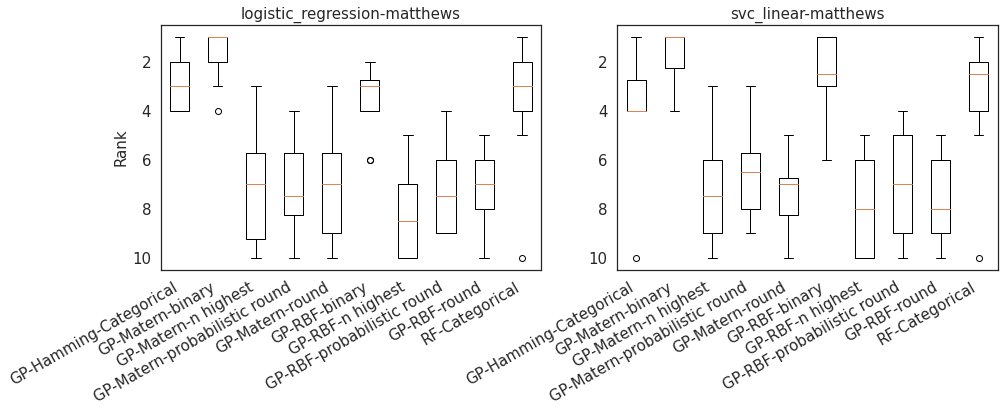

In [409]:
# create BOFS rank boxplot
def createBOFSRankBoxplot(bayopt_data):
    all_bayopt_data_grouped_estimator = all_bayopt_data.groupby(["Estimator", "Metric"])
    
    # init dict
    data_dict = dict()
    for name_estimator, group_estimator in all_bayopt_data_grouped_estimator:
        label_estimator = name_estimator[0] + "-" + name_estimator[1]
        data_dict[label_estimator] = {}
        grouped_approaches = group_estimator.groupby(["Approach", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function", "n_features"])
        for name_approach, _ in grouped_approaches:
            label_approaches = name_approach[1] + "-" + name_approach[2] + "-" + name_approach[3]
            data_dict[label_estimator][label_approaches] = []
    
    # calculate ranks
    for name_estimator, group_estimator in all_bayopt_data_grouped_estimator:
        all_bayopt_data_grouped_did = group_estimator.groupby(["did"])
        estimator_label = name_estimator[0] + "-" + name_estimator[1]
        for name_did, group_did in all_bayopt_data_grouped_did:
            sorted_group = group_did.sort_values(["Testing Score"], ascending=False).reset_index(drop=True)
            for index, row in sorted_group.iterrows():
                row_label = row[1] + "-" + row[2] + "-" + row[3]
                data_dict[estimator_label][row_label].append(index+1)
    df = pd.DataFrame(data_dict)

    labels = []
    for x in df.index:
        if x == "RF---Categorical":
            labels.append("RF-Categorical")
        else:
            labels.append(x)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.boxplot(df[df.columns[0]])
    ax1.set_title(df.columns[0], fontsize=15)
    ax1.set_ylim(0.5,10.5)
    ax1.set_xticklabels(labels)
    ax1.tick_params(labelsize=15)
    ax1.set_ylabel('Rank', size=15)
    ax1.invert_yaxis()
    ax2.boxplot(df[df.columns[1]])
    ax2.set_title(df.columns[1], fontsize=15)
    ax2.set_ylim(0.5,10.5)
    ax2.set_xticklabels(labels)
    ax2.tick_params(labelsize=15)
    ax2.invert_yaxis()
    
    fig.autofmt_xdate()
    
    return fig
            
rank_boxplot = createBOFSRankBoxplot(all_bayopt_data)
rank_boxplot.savefig(comparison_experiment_output_path + "rank_box_plot.pdf", format="pdf", bbox_inches = "tight")

In [ ]:
def createCorrelationMatrixOnlyBayopt(bayopt_data):
    grouped_bayopt_df = bayopt_data.groupby(["Approach", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function", "n_features"])
    
    data_dict = dict()
    for name, group in grouped_bayopt_df:
        if name[1] == "RF":
            label = name[1] + "-" + name[3]
        else:
            label = name[1] + "-" + name[2] + "-" + name[3]
        scores = group["Testing Score"].values
        data_dict[label] = scores
    
    df = pd.DataFrame(data_dict)
    correlation_df = df.corr()
    
    # display only lower diagonal values
    mask = np.zeros_like(correlation_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.diag_indices_from(mask)] = False
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.set(style="white")
    ax = sns.heatmap(data=correlation_df, mask=mask, vmin=-1, vmax=1, cmap='RdYlGn', annot=True, square=True, cbar=False)
    
    return ax

In [ ]:
for name, group in all_bayopt_data.groupby(["Estimator", "Metric"]):
    heatmap_only_bayopt = createCorrelationMatrixOnlyBayopt(group)

In [ ]:
def create_correlation_matrix(bayopt_data, comparison_data, withoutfs_data):
    grouped_bayopt_df = bayopt_data.groupby(["Approach", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function", "n_features"])
    grouped_comparison_df = comparison_data.groupby(["Approach", "Algorithm", "n_features"])
    
    data_dict = dict()
    
    for name, group in grouped_bayopt_df:
        if name[1] == "RF":
            label = name[1] + "-" + name[3]
        else:
            label = name[1] + "-" + name[2] + "-" + name[3]
        scores = group["Testing Score"].values
        data_dict[label] = scores
    for name, group in grouped_comparison_df:
        label = name[1] + " (" + name[0] + ")"
        scores = group["Testing Score"].values
        data_dict[label] = scores
    data_dict["Without FS"] = withoutfs_data["Testing Score"].values

    df = pd.DataFrame(data_dict)
    correlation_df = df.corr()
    
    # display only lower diagonal values
    mask = np.zeros_like(correlation_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.diag_indices_from(mask)] = False
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.set(style="white", font_scale=1.0)
    ax = sns.heatmap(data=correlation_df, mask=mask, vmin=0.5, vmax=1, cmap='RdYlGn', center=0.75, annot=True, square=True, cbar=False)
    
    return ax
    

In [ ]:
grouped_bayopt_data = all_bayopt_data.groupby(["Estimator", "Metric"])
grouped_comparison_data = all_comparison_data.groupby(["Estimator", "Metric"])
grouped_withoutfs_data = all_withoutfs_data.groupby(["Estimator", "Metric"])

for name, group in grouped_bayopt_data:
    heatmap = create_correlation_matrix(group, grouped_comparison_data.get_group(name), grouped_withoutfs_data.get_group(name))
    figure = heatmap.get_figure()
    figure.savefig(comparison_experiment_output_path + "score_correlation_heatmap_" + name[0] + "_" + name[1] + ".pdf", format="pdf", bbox_inches = "tight")
    sns.set(style="white") # reset font size

### 3.2.1 Overall runtime (BOFS vs Comparison)

In [ ]:
def create_box_plot_of_runtime(bayopt_data, comparison_data):
    grouped_bayopt_df = bayopt_data.groupby(["Approach", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function", "n_features"])
    bayopt_durations = []
    bayopt_labels = []
    grouped_comparison_df = comparison_data.groupby(["Approach", "Algorithm", "n_features"])
    comparison_durations = []
    comparison_labels = []
    for name, group in grouped_bayopt_df:
        duration = group["Duration Black Box"] + group["Duration Overhead"]
        bayopt_durations.append(duration.values)
        bayopt_labels.append(name[1] + "-" + name[2] + "-" + name[3] + "-" + name[4])

    for name, group in grouped_comparison_df:
        comparison_durations.append(group["Duration"].values)
        comparison_labels.append(name[1] + " (" + name[0] + ")")

    # Create boxplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.boxplot(bayopt_durations)
    ax1.set_xticklabels(bayopt_labels)
    ax1.set_title("BOFS Overall Runtime")
    ax1.set_ylabel("Runtime [s]") 
    ax2.boxplot(comparison_durations)
    ax2.set_xticklabels(comparison_labels)
    ax2.set_title("Comparison Overall Runtime")
    ax2.set_ylabel("Runtime [s]") 

    # set y axis range to the same for both subplots
    y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
    ax1.set_ylim(0, y_max)
    ax2.set_ylim(0, y_max)

    fig.autofmt_xdate()
    
    return fig
    

In [ ]:
runtime_box_plot = create_box_plot_of_runtime(all_bayopt_data, all_comparison_data)
runtime_box_plot.savefig(comparison_experiment_output_path + "runtime_comparison_box_plot.pdf", format="pdf", bbox_inches = "tight")

#iteration_box_plot = create_box_plot_of_number_of_iterations(all_bayopt_data)


#plot = create_box_plot_of_bayopt_runtime(bayopt_data)
#filename = dataset_id + "_" + estimator + "_" + metric + ".eps"
#plot.savefig(comparison_experiment_output_path + filename, format="eps", bbox_inches = "tight")
    
    

## 3.2.2 Dependence of runtime to number of features 

In [ ]:
bayopt_data_with_did = pd.merge(all_bayopt_data, dataset_properties, on="did", how="inner") # merge properties about datasets
bayopt_data_with_did_grouped = bayopt_data_with_did.groupby(["Estimator", "Metric"])

print(all_bayopt_data)
print(bayopt_data_with_did)

for (estimator, metric), group_did in bayopt_data_with_did_grouped:
    bayopt_data_with_estimator_metric_grouped = group_did.groupby(["Approach", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function", "n_features"])
    plt.title(estimator + "-" + metric)
    for name, group in bayopt_data_with_estimator_metric_grouped:
        label = name[1] + "-" + name[2] + "-" + name[3] + "-" + name[4]
        group = group.sort_values(by=["NumberOfFeatures"])
        plt.plot(group["NumberOfFeatures"], group["Duration Black Box"] + group["Duration Overhead"], "-o", label=label)
        plt.xlabel("Number of Features") 
        plt.ylabel("Runtime [s]")
        plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.savefig(comparison_experiment_output_path + "runtime_plots/nr_of_features_dependence_"+estimator+"_"+metric+".eps", format="eps", bbox_inches = "tight")
    plt.show()


## 3.2.3 BOFS Runtime

In [ ]:
all_bayopt_grouped = all_bayopt_data.groupby(["Estimator", "Metric"])
data = {}

for (estimator, metric), group_did in all_bayopt_grouped:
    bayopt_data_with_estimator_metric_grouped = group_did.groupby(["Approach", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function", "n_features"])
    values_black_box = []
    values_overhead = []
    labels_bay_opt = []
    data_dict = dict()
    for name, group in bayopt_data_with_estimator_metric_grouped:
        values_black_box.append(sum(group["Duration Black Box"])/len(group["Duration Black Box"]))
        values_overhead.append(sum(group["Duration Overhead"])/len(group["Duration Overhead"]))
        if name[1] == "RF":
            labels_bay_opt.append(name[1] + "-" + name[3])
        else:
            labels_bay_opt.append(name[1] + "-" + name[2] + "-" + name[3])
    data[estimator + "_" + metric] =  (labels_bay_opt, values_black_box, values_overhead)

df = pd.DataFrame(data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.bar(df[df.columns[0]][0], df[df.columns[0]][2], label="Overhead Runtime")
ax1.bar(df[df.columns[0]][0], df[df.columns[0]][1], bottom=df[df.columns[0]][2], label="Black Box Evaluation Runtime")
ax1.set_ylabel("Average runtime [s]", size=15)
ax1.set_title(df.columns[0], size=15)
ax1.legend()
ax1.tick_params(labelsize=15)
ax2.bar(df[df.columns[1]][0], df[df.columns[1]][2], label="Overhead Runtime")
ax2.bar(df[df.columns[1]][0], df[df.columns[1]][1], bottom=df[df.columns[1]][2], label="Black Box Evaluation Runtime")
ax2.set_title(df.columns[1], size=15)
ax2.legend()
ax2.tick_params(labelsize=15)
# set y axis range to the same for both subplots
y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(0, y_max)
ax2.set_ylim(0, y_max)
fig.autofmt_xdate()
plt.savefig(comparison_experiment_output_path + "runtime_plots/bofs_average_runtime.pdf", format="pdf", bbox_inches = "tight")
plt.show()

## 3.2.3. BOFS Division of black-box-runtime and overhead runtime

In [ ]:
# Bar plot of runtime in seconds throughout the different datasets (divided into black box evaluation and overhead runtime)
all_bayopt_grouped = all_bayopt_data.groupby(["Estimator", "Metric"])
all_comparison_grouped = all_comparison_data.groupby(["Estimator", "Metric"])

for (estimator, metric), group_did in all_bayopt_grouped:
    bayopt_data_with_estimator_metric_grouped = group_did.groupby(["Approach", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function", "n_features"])
    values_black_box = []
    values_overhead = []
    labels_bay_opt = []
    for name, group in bayopt_data_with_estimator_metric_grouped:
        values_black_box.append(sum(group["Duration Black Box"])/len(group["Duration Black Box"]))
        values_overhead.append(sum(group["Duration Overhead"])/len(group["Duration Overhead"]))
        if name[1] == "RF":
            labels_bay_opt.append(name[1] + "-" + name[3])
        else:
            labels_bay_opt.append(name[1] + "-" + name[2] + "-" + name[3])
    
    comparison_group = all_comparison_grouped.get_group((estimator, metric))
    comparison_data_with_estimator_metric_grouped = comparison_group.groupby(["Approach", "Algorithm", "n_features"])
    values_comparison = []
    labels_comparison = []
    for name, group in comparison_data_with_estimator_metric_grouped:
        values_comparison.append(sum(group["Duration"].values)/len(group["Duration"].values))
        labels_comparison.append(name[1] + " (" + name[0] + ")")
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.set_title("BOFS")
    ax1.bar(labels_bay_opt, values_overhead, label="Overhead Runtime")
    ax1.bar(labels_bay_opt, values_black_box, bottom=values_overhead, label="Black Box Evaluation Runtime")
    ax1.legend()
    ax1.set_ylabel("Average runtime [s]")
    ax2.set_title("Comparison")
    ax2.bar(labels_comparison, values_comparison, label="Overall Runtime")
    ax2.legend()
    ax2.set_ylabel("Average runtime [s]")
    # set y axis range to the same for both subplots
    y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
    ax1.set_ylim(0, y_max)
    ax2.set_ylim(0, y_max)
    
    fig.autofmt_xdate()
    fig.savefig(comparison_experiment_output_path + "runtime_plots/avg_bayesian_divided_runtime_"+estimator+"_"+metric+".pdf", format="pdf", bbox_inches = "tight")
    fig.show()        

## 3.2.4. BOFS number of average iterations

In [ ]:
# Box plot of number of iterations until convergence (50 iterations without new optimum) throughout the different datasets
all_bayopt_grouped = all_bayopt_data.groupby(["Estimator", "Metric"])

res_dict = dict()
for (estimator, metric), group_did in all_bayopt_grouped:
    bayopt_data_with_estimator_metric_grouped = group_did.groupby(["Approach", "Learning Method", "Kernel", "Discretization Method", "Acquisition Function", "n_features"])
    values = []
    labels = []
    res_dict[estimator + "-" + metric] = {}
    for name, group in bayopt_data_with_estimator_metric_grouped:
        values = group["Number of Iterations"].values
        if name[1] == "RF":
            label = name[1] + "-" + name[3]
        else:
            label = name[1] + "-" + name[2] + "-" + name[3]
        res_dict[estimator + "-" + metric][label] = values

df = pd.DataFrame(res_dict)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_title(df.columns[0], size=15)
ax1.boxplot(df[df.columns[0]])
ax1.set_xticklabels(df.index)
ax1.set_ylabel("Iterations to convergence", size=15)
ax1.tick_params(labelsize=15)

ax2.set_title(df.columns[1], size=15)
ax2.boxplot(df[df.columns[1]])
ax2.set_xticklabels(df.index)
ax2.tick_params(labelsize=15)
fig.autofmt_xdate()
fig.savefig(comparison_experiment_output_path + "runtime_plots/boxplot_bayesian_iterations.pdf", format="pdf", bbox_inches = "tight")
fig.show()